In [1]:
# TODO: Use this to profile: https://stackoverflow.com/questions/45893768/how-do-i-find-out-what-parts-of-my-code-are-inefficient-in-python
%load_ext line_profiler

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import holidays
import dataclasses
import datetime
import pprint
import statistics

from datetime import timedelta
from enum import Enum, auto
from typing import List, Optional, Tuple, Set
from pandas.tseries.offsets import BDay
pd.set_option('display.max_colwidth', None)

pp = pprint.PrettyPrinter(indent=4)

In [3]:
API_KEY = 'cfg2wsKZrVNuYBJpETAs'
DEVELOPMENT = False

if DEVELOPMENT:
    daily_metrics = pd.read_csv('SHARADAR-DAILY.csv')
    daily_prices = pd.read_csv('SHARADAR-SEP.csv')
else:
    daily_metrics = pd.read_csv('SHARADAR_DAILY_3_9ffd00fad4f19bbdec75c6e670d3df83.csv')
    daily_prices = pd.read_csv('SHARADAR_SEP_2_0bd2000858d1d8d1f48d4cdea5f8c9e2.csv')

In [4]:
d1 = daily_metrics.copy()

d2 = daily_prices[['ticker', 'date','closeadj']]
d2.rename(columns={'closeadj': 'price'}, inplace=True)

daily_data = d1.merge(d2, on=['date', 'ticker'], how='inner')
daily_data

/Users/olshansky/.pyenv/versions/3.7.7/envs/tip_env/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps,price
0,A,2020-12-18,2020-12-18,37525.1,40.8,30.6,36607.1,7.5,50.9,6.9,118.928
1,AA,2020-12-18,2020-12-18,4896.3,-43.0,8.9,4092.3,1.2,-8.7,0.4,22.010
2,AACQ,2020-12-18,2020-12-18,943.3,NaN,NaN,944.6,188.9,NaN,NaN,10.430
3,AAIC,2020-12-18,2020-12-18,817.6,-15.8,-15.8,125.0,0.5,-2.3,5.3,3.740
4,AAIIQ,2020-12-18,2020-12-18,-2.8,0.5,0.8,0.4,0.0,-0.1,0.0,0.100
...,...,...,...,...,...,...,...,...,...,...,...
14551055,GSTCQ,2011-01-04,2021-05-30,235.6,3.4,3.0,218.6,1.4,-575.3,5.0,4.340
14551056,MHRCQ,2011-01-04,2021-05-30,471.6,-29.7,-64.3,419.2,6.0,-19.3,13.6,7.230
14551057,EPRSQ,2011-01-03,2021-05-30,153.1,187.2,8.6,155.8,2.1,74.4,2.9,105.000
14551058,GSTCQ,2011-01-03,2021-05-30,242.7,3.5,3.1,225.7,1.4,-593.9,5.1,4.480


In [379]:
@dataclasses.dataclass
class ShareAllocation:
    ticker: str
    num_shares: float
        
@dataclasses.dataclass
class Stock:
    ticker: str
    price: float        
        
class StockUniverse(Enum):
    SMALL = auto()  # < $1B
    MID = auto()  # $1B - $10B
    LARGE = auto()  # > $100B
    
class StockBasketWeightApproach(Enum):
    EQUAL_WEIGHTING = auto()
#     MARKET_CAP_ADJUSTED = auto()

class EvaluationMetric(Enum):
    EV_EBIT = auto()
    P_E = auto()
    P_B = auto()
    DIV_YIELD = auto()

    def __str__(self):
        if self.value == EvaluationMetric.EV_EBIT.value:
            return 'EV/EBIT'
        elif self.value == EvaluationMetric.P_E.value:
            return 'P/E'
        elif self.value == EvaluationMetric.P_B.value:
            return 'P/B'
        elif self.value == EvaluationMetric.DIV_YIELD.value:
            return '% Div Yield'
        else:
            raise Exception(f'Unsupported evaluation metric {metric}')
    
def get_closest_previous_work_day(
    check_day: datetime.datetime,
    holidays=holidays.US()
) -> datetime.datetime:
    if check_day.weekday() <= 4 and check_day not in holidays:
        return check_day
    offset = max(1, (check_day.weekday() + 6) % 7 - 3)
    most_recent = check_day - datetime.timedelta(offset)
    if most_recent not in holidays:
        return most_recent
    else:
        return get_closest_previous_work_day(most_recent, holidays)

def get_rebalance_dates(
    start_date: datetime.datetime,
    end_date: datetime.datetime,
    period_length: datetime.timedelta
) -> List[datetime.datetime]:
    curr_date = start_date
    dates = []
    while curr_date < end_date:
        dates.append(get_closest_previous_work_day(curr_date))
        curr_date += period_length
    return dates

# Assumes data is already filtered by date
def filter_stocks_by_universe(
    df: pd.DataFrame,
    stocks_universe: StockUniverse
) -> pd.DataFrame:
    if stocks_universe.value == StockUniverse.SMALL.value:
        return df[df['marketcap'] < 1]
    elif stocks_universe.value == StockUniverse.MID.value:
        return df[(df['marketcap'] >= 1) & (df['marketcap'] <= 10)]
    elif stocks_universe.value == StockUniverse.LARGE.value:
        return df[(df['marketcap'] >= 10)]
    else:
        raise Exception(f'Unsupported stock universe {stocks_universe}')

def sort_df_by_metric(
    df: pd.DataFrame,
    metric: EvaluationMetric
) -> pd.DataFrame:
    if metric.value == EvaluationMetric.EV_EBIT.value:
        return df.sort_values(by='evebit')
    elif metric.value == EvaluationMetric.P_E.value:
        return df.sort_values(by='pe')
    elif metric.value == EvaluationMetric.P_B.value:
        return df.sort_values(by='pb')
    elif metric.value == EvaluationMetric.DIV_YIELD.value:
        raise Exception('EvaluationMetric.DIV_YIELD not yet supported.')
    else:
        raise Exception(f'Unsupported evaluation metric {metric}')

# Assumes df is sorted by date
def get_last_available_price(
    df: pd.DataFrame,
    ticker: str
) -> int:
    return df[df.ticker == ticker].iloc[-1]['price']

# Assumes df is sorted appropriately ahead of time.
def get_top_n_stocks_by_metric(
    df: pd.DataFrame,
    n: int,
    metric: EvaluationMetric    
) -> List[str]:
    df_res = None
    if metric.value == EvaluationMetric.EV_EBIT.value:
        df_res = df[(df['evebit'] > 0) & (df['ev'] > 0)]
    elif metric.value == EvaluationMetric.P_E.value:
        df_res = df[df['pe'] > 0]
    elif metric.value == EvaluationMetric.P_B.value:
        df_res = df[df['pb'] > 0]
    elif metric.value == EvaluationMetric.DIV_YIELD.value:
        raise Exception('EvaluationMetric.DIV_YIELD not yet supported.')
    else:
        raise Exception(f'Unsupported evaluation metric {metric}')
    
    return list(df_res[:n]['ticker'])

def filter_df_by_date(
    df: pd.DataFrame,
    date: datetime.datetime
) -> pd.DataFrame:
    return df[df.date == date.strftime('%Y-%m-%d')]

def get_stock_basket_price(
    df: pd.DataFrame, # Assume filtered by specific date
    df_full: pd.DataFrame, # Used to get the prices for stocks that closed
    tickers: List[str],
    should_print = False
) -> Tuple[int, Set[str]]:
    stocks_of_interest = df.loc[df['ticker'].isin(tickers)]
    assert len(tickers) >= len(stocks_of_interest)
    basket_price = stocks_of_interest['price'].sum()
    missing_stocks = set(tickers) - set(stocks_of_interest['ticker'])    
    if should_print:
        print('Stocks closed:', missing_stocks)
    for missing_ticker in missing_stocks:
        basket_price += get_last_available_price(df_full, missing_ticker)
    return (round(basket_price, 2), missing_stocks)

def get_stock_price_per_stock(
    df: pd.DataFrame,
    df_prev: Optional[pd.DataFrame],    
    df_full: pd.DataFrame,
    tickers: List[str]
) -> Tuple[str, int]:
    res = []
    stocks_of_interest = df.loc[df['ticker'].isin(tickers)]
    missing_stocks = set(tickers) - set(stocks_of_interest['ticker'])
    
    for idx, r in stocks_of_interest.iterrows():
        ticker = r['ticker']
        price = r['price']
        prev_price = df_prev[df_prev['ticker'] == ticker]['price'].iloc[0] if df_prev is not None else 'NA'
        res.append((ticker, prev_price, price))

    for missing_ticker in missing_stocks:
        prev_price = df_prev[df_prev['ticker'] == missing_ticker]['price'].iloc[0] if df_prev is not None else 'NA'
        price = get_last_available_price(df_full, missing_ticker)
        res.append((missing_ticker, prev_price, price))
        
    res.sort(key = lambda t: t[0])
    return res

def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse
):
    df_to_plot = df[['base_portfolio_value', 'test_portfolio_value']]
    df_to_plot.plot(title=(
        f'{str(base_metric)} (base)'
        f' VS {str(test_metric)} (test)\n'
        f' Rebalance freq: {rebalance_days} days\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))

def get_share_allocation(
    df: pd.DataFrame, # Assume filtered by specific date
    tickers: List[str], # portfolio
    investment_amount: int,
    weight_approach: StockBasketWeightApproach
) -> List[ShareAllocation]:
    if weight_approach != StockBasketWeightApproach.EQUAL_WEIGHTING:
        raise Exception(f'{weight_approach} not supported yet.')
    amount_per_stock = investment_amount / len(tickers)
    res = []
    for ticker in tickers:
        price = df[df['ticker'] == ticker]['price'].iloc[0]
        num_shares = amount_per_stock / price
        res.append(ShareAllocation(ticker, num_shares))
    return res    
    
    
def get_portfolio_value(
    df: pd.DataFrame, # Assume filtered by specific date,
    share_allocation: List[ShareAllocation]
) -> float:
    total = 0
    for allocation in share_allocation:
        price = df[df.ticker == allocation.ticker]['price'].iloc[0]
        total += (price * allocation.num_shares)
    return total

def get_stock_basket_price_by_share_allocation(
    df: pd.DataFrame, # Assume filtered by specific date
    df_full: pd.DataFrame, # Used to get the prices for stocks that closed
    share_allocation: List[ShareAllocation],
    should_print = False
) -> Tuple[float, Set[str]]:
    tickers = [alloc.ticker for alloc in share_allocation]
    stocks_of_interest = df.loc[df['ticker'].isin(tickers)]
    missing_stocks = set(tickers) - set(stocks_of_interest['ticker'])
    basket_price = 0
    for alloc in share_allocation:
        ticker = alloc.ticker
        if ticker in missing_stocks:
            price = get_last_available_price(df_full, ticker)
        else:
            price = df[df.ticker == ticker]['price'].iloc[0]
        basket_price += (price * alloc.num_shares)
    return (round(basket_price, 2), missing_stocks)
    
# get_stock_price_per_stock(base_sorted_df, prev_base_sorted_df, date_sorted_daily_data, base_portfolio)
# base_sorted_df[base_sorted_df['ticker'] == 'CVVT']
# prev_base_sorted_df[prev_base_sorted_df['ticker'] == 'CVVT']
# date_sorted_daily_data[date_sorted_daily_data['ticker'] == 'CVVT']
# get_last_available_price(date_sorted_daily_data, 'CVVT')

# share_allocation = get_share_allocation(daily_data_df, base_portfolio, 1000, StockBasketWeightApproach.EQUAL_WEIGHTING)

# print(get_portfolio_value(daily_data_df, share_allocation))
# print(get_portfolio_value(prev_daily_data_df, share_allocation))
# print(get_stock_basket_price_by_share_allocation(daily_data_df, date_sorted_daily_data, share_allocation))
# print(get_stock_basket_price_by_share_allocation(prev_daily_data_df, date_sorted_daily_data, share_allocation))

1000.0000000000005
1205.1922455406545
(1000.0, set())
(1205.19, set())


In [315]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    
def color_per_cell(v):
    per = float(v[:-1])
    if per < -25:
        return "background-color: orangered"
    elif per >= -25 and per < 0:
        return "background-color: #ffcccb"
    elif per >= 0 and per < 25:
        return "background-color: #90ee90"
    elif per >= 25:
        return "background-color: green"    


In [6]:
# Prepare Inputs for Base + Test
INITIAL_PORTFOLIO_VALUE = 10000
PORTFOLIO_SIZE = 30
REBALANCE_DAYS = 365 

base_metric = EvaluationMetric.EV_EBIT
test_metric = EvaluationMetric.P_B
stocks_universe = StockUniverse.LARGE

# Optimization: Sorting every time would take too long
date_sorted_daily_data = daily_data.sort_values(by='date')
base_sorted_daily_data = sort_df_by_metric(daily_data, base_metric)
test_sorted_daily_data = sort_df_by_metric(daily_data, test_metric)

In [389]:
stocks_universe = StockUniverse.LARGE
base_metric = EvaluationMetric.EV_EBIT
test_metric = EvaluationMetric.P_B

start_date = datetime.datetime.strptime(min(daily_data['date']), '%Y-%m-%d')
end_date = datetime.datetime.strptime(max(daily_data['date']), '%Y-%m-%d')
        
rebalance_dates = get_rebalance_dates(start_date, end_date, timedelta(days=90))

value_for_share_allocation = 1000
base_portfolio_value = INITIAL_PORTFOLIO_VALUE
test_portfolio_value = INITIAL_PORTFOLIO_VALUE
portfolio_size = PORTFOLIO_SIZE
portfolio_weight_strategy = StockBasketWeightApproach.EQUAL_WEIGHTING

start_date = rebalance_dates[0]

daily_data_df = filter_df_by_date(date_sorted_daily_data, start_date)
base_sorted_df = filter_df_by_date(base_sorted_daily_data, start_date)
test_sorted_df = filter_df_by_date(test_sorted_daily_data, start_date)

base_sorted_df = filter_stocks_by_universe(base_sorted_df, stocks_universe)
test_sorted_df = filter_stocks_by_universe(test_sorted_df, stocks_universe)

base_portfolio = get_top_n_stocks_by_metric(base_sorted_df, portfolio_size, base_metric)
test_portfolio = get_top_n_stocks_by_metric(test_sorted_df, portfolio_size, test_metric)

base_share_allocation = get_share_allocation(daily_data_df, base_portfolio, value_for_share_allocation, portfolio_weight_strategy)
test_share_allocation = get_share_allocation(daily_data_df, test_portfolio, value_for_share_allocation, portfolio_weight_strategy)

# base_price, base_tickers_closed = get_stock_basket_price(base_sorted_df, date_sorted_daily_data, base_portfolio)
# test_price, test_tickers_closed = get_stock_basket_price(test_sorted_df, date_sorted_daily_data, test_portfolio)

base_price, base_tickers_closed = get_stock_basket_price_by_share_allocation(base_sorted_df, date_sorted_daily_data, base_share_allocation)
test_price, test_tickers_closed = get_stock_basket_price_by_share_allocation(test_sorted_df, date_sorted_daily_data, test_share_allocation)
assert value_for_share_allocation == base_price
assert value_for_share_allocation == test_price

debug = {}
res = {}
res[start_date] = {
    'base_basket_price': base_price,
    'base_portfolio_value': base_portfolio_value,
    'test_basket_price': test_price,
    'test_portfolio_value': test_portfolio_value,        
}

prev_base_price = base_price
prev_test_price = test_price
prev_date = start_date

# for date in rebalance_dates[2:4]:
for date in rebalance_dates:
    print(date.strftime('%Y-%m-%d'))

    # Filter for optimization purposes
    daily_data_df = filter_df_by_date(date_sorted_daily_data, date)
    base_sorted_df = filter_df_by_date(base_sorted_daily_data, date)
    test_sorted_df = filter_df_by_date(test_sorted_daily_data, date)
    
    prev_daily_data_df = filter_df_by_date(date_sorted_daily_data, prev_date)
    prev_base_sorted_df = filter_df_by_date(base_sorted_daily_data, prev_date)
    prev_test_sorted_df = filter_df_by_date(test_sorted_daily_data, prev_date)    

    # V1: Compute value of previous portfolio
#     base_price, base_tickers_closed = get_stock_basket_price(base_sorted_df, date_sorted_daily_data, base_portfolio, should_print=True)
#     test_price, test_tickers_closed = get_stock_basket_price(test_sorted_df, date_sorted_daily_data, test_portfolio)

    # V2: Compute value of previous portfolio
    base_price, base_tickers_closed = get_stock_basket_price_by_share_allocation(base_sorted_df, date_sorted_daily_data, base_share_allocation)
    test_price, test_tickers_closed = get_stock_basket_price_by_share_allocation(test_sorted_df, date_sorted_daily_data, test_share_allocation)

    # Undersand change in previous portfolio
    base_change = base_price / prev_base_price
    test_change = test_price / prev_test_price

    # Compute new prtfolio value
    base_portfolio_value = round(base_portfolio_value * base_change, 2)
    test_portfolio_value = round(test_portfolio_value * test_change, 2)    

    res[date] = {
        'base_basket_price': base_price,
        'base_portfolio_value': base_portfolio_value,
        'test_basket_price': test_price,
        'test_portfolio_value': test_portfolio_value,        
    }
    
    debug[date] = {
        'prev_date': prev_date,
        'prev_base_portfolio_prev_price': prev_base_price,
        'prev_base_portfolio_curr_price': base_price,
        'tickers_closed': base_tickers_closed,
        'prev_base_portfolio': get_stock_price_per_stock(base_sorted_df, prev_base_sorted_df, date_sorted_daily_data, base_portfolio),                
    }
    
    # Filter for optimization purposes
    base_sorted_df = filter_stocks_by_universe(base_sorted_df, stocks_universe)
    test_sorted_df = filter_stocks_by_universe(test_sorted_df, stocks_universe)    

    # Update portfolio
    base_portfolio = get_top_n_stocks_by_metric(base_sorted_df, portfolio_size, base_metric)
    test_portfolio = get_top_n_stocks_by_metric(test_sorted_df, portfolio_size, test_metric)

    base_share_allocation = get_share_allocation(daily_data_df, base_portfolio, value_for_share_allocation, portfolio_weight_strategy)
    test_share_allocation = get_share_allocation(daily_data_df, test_portfolio, value_for_share_allocation, portfolio_weight_strategy)    
    
    # V1: Get new portfolio price
#     base_price, base_tickers_closed = get_stock_basket_price(base_sorted_df, date_sorted_daily_data, base_portfolio)
#     test_price, test_tickers_closed = get_stock_basket_price(test_sorted_df, date_sorted_daily_data, test_portfolio)
    
    # V2: Get new portfolio price    
    base_price, base_tickers_closed = get_stock_basket_price_by_share_allocation(base_sorted_df, date_sorted_daily_data, base_share_allocation)
    test_price, test_tickers_closed = get_stock_basket_price_by_share_allocation(test_sorted_df, date_sorted_daily_data, test_share_allocation)    
    
    # Cache the last price of the current portfolio (previous date)
    prev_base_price = base_price
    prev_test_price = test_price
    prev_date = date
    
    debug[date].update({
        'new_base_portfolio_value': base_price,        
        'new_base_portfolio': get_stock_price_per_stock(base_sorted_df, None, date_sorted_daily_data, base_portfolio),
    })
    
df_res = pd.DataFrame.from_dict(res, orient='index')
df_debug = pd.DataFrame.from_dict(debug, orient='index')    

2011-01-03
2011-04-01
2011-07-01
2011-09-30
2011-12-29
2012-03-28
2012-06-26
2012-09-24
2012-12-21
2013-03-22
2013-06-21
2013-09-19
2013-12-18
2014-03-18
2014-06-16
2014-09-12
2014-12-12
2015-03-13
2015-06-11
2015-09-09
2015-12-08
2016-03-07
2016-06-03
2016-09-02
2016-12-02
2017-03-02
2017-05-31
2017-08-29
2017-11-27
2018-02-23
2018-05-25
2018-08-24
2018-11-21
2019-02-20
2019-05-21
2019-08-19
2019-11-15
2020-02-14
2020-05-15
2020-08-13
2020-11-10
2021-02-09
2021-05-10


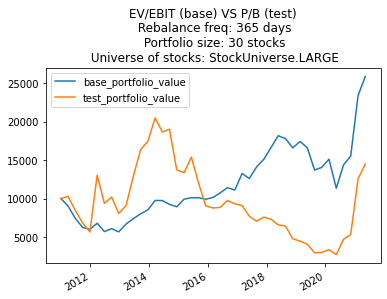

In [390]:
plot_backtest(df_res, base_metric, test_metric, REBALANCE_DAYS, PORTFOLIO_SIZE, stocks_universe)

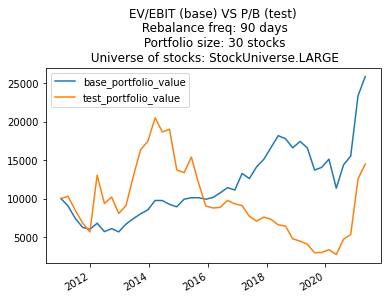

In [391]:
plot_backtest(df_res, base_metric, test_metric, 90, PORTFOLIO_SIZE, stocks_universe)

In [392]:
def tuple_array_to_df(tuple_arr):
    df = pd.DataFrame.from_records(tuple_arr, columns=['ticker', 'before', 'after'])
    df['ticker'] = df['ticker'].str.replace("'", "")
    return df

def per_stocks_up(tupple_arr):
    return f'{round(100 * sum([1 for (ticker, before, after) in tupple_arr if (after > before)]) / len(tupple_arr), 2)}%'

def p_change(r):
    return f'{round(100 * (r.prev_base_portfolio_curr_price - r.prev_base_portfolio_prev_price ) / r.prev_base_portfolio_prev_price, 2)}%'

def p_change2(r):
    return f'{round(100 * (r.after - r.before ) / r.before, 2)}%'

def get_date_based_df(df_debug, date):
    df_date = df_debug.loc[date]
    tuple_arr = df_date['prev_base_portfolio']
    df = tuple_array_to_df(tuple_arr)
    tickers_closed = [str(s) for s in df_date['tickers_closed']]
    df['up'] = df.apply(lambda r: r['after'] > r['before'], axis=1)
    df['per_change'] = df.apply(lambda r: p_change2(r), axis=1)
    print(tickers_closed)
    df['did_close'] = df.apply(lambda r: "Closed" if str(r.ticker) in tickers_closed else "", axis=1)
    df = df.sort_values(by='per_change', key=lambda col: col.map(lambda v: float(v[:-1])))    
    summary_row = [
        'Summary / Total ',
        round(sum(df['before']), 20),
        round(sum(df['after']), 20),
        f"{round(100 * sum(df['up']) / len(df['up']))}%",
        f"{round(statistics.mean([float(p[:-1]) for p in df['per_change']]), 2)}%",
        ""
    ]
    df.loc[len(df.index)] = summary_row
    return df

date_investigation = rebalance_dates[7]

df_debug['per_stock_up'] = df_debug.apply(lambda r: per_stocks_up(list(r.prev_base_portfolio)), axis=1)
df_debug['portfolio_change'] = df_debug.apply(lambda r: p_change(r), axis=1)

df_debug_readable = df_debug.copy()
df_debug_readable['num_tickers_closed'] = df_debug_readable.apply(lambda r: len(r.tickers_closed), axis=1)
df_debug_readable = df_debug.drop(['tickers_closed', 'prev_base_portfolio', 'new_base_portfolio', 'new_base_portfolio_value'], axis=1)
df_debug_readable.rename(columns={'prev_base_portfolio_prev_price': 'prev', 'prev_base_portfolio_curr_price': 'curr'}, inplace=True)

df_date = get_date_based_df(df_debug, date_investigation)

[]


In [393]:
df_debug_readable.style.applymap(color_per_cell, subset=['per_stock_up', 'portfolio_change'])

,prev_date,prev,curr,per_stock_up,portfolio_change
2011-01-03 00:00:00,2011-01-03 00:00:00,1000.000000,1000.000000,0.0%,0.0%
2011-04-01 00:00:00,2011-01-03 00:00:00,1000.000000,904.330000,36.67%,-9.57%
2011-07-01 00:00:00,2011-04-01 00:00:00,1000.000000,818.460000,33.33%,-18.15%
2011-09-30 00:00:00,2011-07-01 00:00:00,1000.000000,843.650000,20.0%,-15.64%
2011-12-29 00:00:00,2011-09-30 00:00:00,1000.000000,958.800000,46.67%,-4.12%
2012-03-28 00:00:00,2011-12-29 00:00:00,1000.000000,1132.890000,80.0%,13.29%
2012-06-26 00:00:00,2012-03-28 00:00:00,1000.000000,839.150000,33.33%,-16.09%
2012-09-24 00:00:00,2012-06-26 00:00:00,1000.000000,1068.060000,60.0%,6.81%
2012-12-21 00:00:00,2012-09-24 00:00:00,1000.000000,930.560000,33.33%,-6.94%
2013-03-22 00:00:00,2012-12-21 00:00:00,1000.000000,1181.140000,70.0%,18.11%


In [394]:
df_with_style = df_date.style \
    .set_caption(f"Rebalance results on {datetime.datetime.strftime(date_investigation, '%Y-%m-%d')} for {str(stocks_universe)}") \
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('text-align', 'center'),        
    ]
}])
df_with_style.applymap(color_per_cell, subset=['per_change'])

,ticker,before,after,up,per_change,did_close
10,CVVT,1.240000,0.521000,False,-57.98%,
6,CHOPF,27.800000,17.800000,False,-35.97%,
4,CDII,0.325000,0.220000,False,-32.31%,
16,LIWA,5.380000,3.710000,False,-31.04%,
14,GPRC,1.680000,1.420000,False,-15.48%,
20,MY,1.320000,1.120000,False,-15.15%,
18,MOBI,2.170000,2.060000,False,-5.07%,
19,MSN,1.344000,1.286000,False,-4.32%,
28,WSTL,8.960000,8.800000,False,-1.79%,
2,BCSB,13.500000,13.450000,False,-0.37%,
